# GPT-2 Classifier (no pretraining)

In this notebook we will train a GPT-2 classifier from scratch for the proxy task.

This notebook is adapted from [this](https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2) blog post.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import GPT2Model, GPT2DoubleHeadsModel, GPT2Config
import eval_models
from train_utils import *

/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dyang/anaconda3/envs/test_env/lib/pyt

In [3]:
import fastai
import transformers
import tokenizers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('tokenizers version :', tokenizers.__version__)

fastai version : 1.0.61
transformers version : 2.4.1
tokenizers version : 0.4.2


In [4]:
torch.cuda.set_device(1)

### Prep databunch

In [5]:
bs = 32
seed = 42
tok_model_dir = '/home/dyang/InstrumentID/tokenizer/gpt2_tok/shift0''
max_seq_len = 256

In [6]:
cust_tok = CustomTokenizer(TransformersBaseTokenizer, tok_model_dir, max_seq_len)
transformer_base_tokenizer = TransformersBaseTokenizer(tok_model_dir, max_seq_len)
transformer_vocab =  TransformersVocab(tokenizer = transformer_base_tokenizer._pretrained_tokenizer)

In [7]:
pad_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<pad>')
cls_idx = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('</s>')
cls_idx_other = transformer_base_tokenizer._pretrained_tokenizer.token_to_id('<s>')

In [8]:
bpe_path = Path('/home/dyang/InstrumentID/train_data')
train_df = pd.read_csv(bpe_path/'train_df-frag128.char.csv')
valid_df = pd.read_csv(bpe_path/'valid_df-frag128.char.csv')
test_df = pd.read_csv(bpe_path/'test_df-frag128.char.csv')

In [9]:
len(valid_df.iloc[0]['Fragment'])

1151

In [10]:
data_clas = TextDataBunch.from_df(bpe_path, train_df, valid_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

### Train Classifier

In [11]:
model_class, config_class = GPT2Model, GPT2Config

In [12]:
lang_model_path = "/home/dyang/InstrumentID/config.json" #/home/dyang/.fastai/data/bscore_lm/bpe_data/models/gpt2_train-target_lm'
config = config_class.from_pretrained(lang_model_path)
config.num_labels = data_clas.c

In [24]:
lang_model_path = '/home/dyang/.fastai/data/bscore_lm/bpe_data/models/gpt2_train-target_lm'
config = config_class.from_pretrained(lang_model_path)
config.num_labels = data_clas.c

In [14]:
transformer_model = model_class(config)
gpt2_clas = GPT2Classifier(transformer_model, config, pad_idx, cls_idx)

In [15]:
# learner.destroy()
# torch.cuda.empty_cache()

In [25]:
learner = Learner(data_clas, gpt2_clas, metrics=[accuracy, FBeta(average = 'macro', beta=1)])

In [17]:
learner.model

GPT2Classifier(
  (transformer): GPT2Model(
    (wte): Embedding(30000, 768)
    (wpe): Embedding(514, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerN

In [47]:
learner.data

TextClasDataBunch;

Train: LabelList (28800 items)
x: TextList
<s> 一丄一一一一一一</w> 一丂一一一一一一</w> 一丠一一一一一一</w> 一乀一一一一一一</w> 一乀一一一一一一</w> 一丁一一一一一一</w> 亀一一一一一一一</w> 一丂一一一一一一</w> 一亀一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丈一一一一一一</w> 一丂一一一一一一</w> 一丁一一一一一一</w> 一丠一一一一一一</w> 一丂一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一丄一一一一一一</w> 一丂一一一一一一</w> 一丐一一一一一一</w> 一丈丁一一一一一</w> 一亄一一一一一一</w> 一丠丄一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一乀一一一一一一</w> 一亀一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丄一一一一一一</w> 亀一一一一一一一</w> 一丂一一一一一一</w> 一丄一一一一一一</w> 一丈一一一一一一</w> 一乀一一一一一一</w> 一丠一一一一一一</w> 一亀一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一亀一一一一一一</w> 一乀一一一一一一</w> 一乀一一一一一一</w> 一乀一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一乀一一一一一一</w> 一丠一一一一一一</w> 一丂一一一一一一</w> 一丄一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</w> 一丐一一一一一一</w> 一丈一一一一一一</w> 一丐一一一一一一</w> 一丠一一一一一一</

In [48]:
list_layers = [learner.model.transformer.wte, 
               learner.model.transformer.wpe, 
               learner.model.transformer.h[0],
               learner.model.transformer.h[1],
               learner.model.transformer.h[2],
               learner.model.transformer.h[3],
               learner.model.transformer.h[4],
               learner.model.transformer.h[5],
               learner.model.transformer.ln_f]

In [49]:
learner.split(list_layers)
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30000, 768)
), Sequential(
  (0): Embedding(514, 768)
  (1): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1D()
  (7): Conv1D()
  (8): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Conv1D()
  (2): Conv1D()
  (3): Dropout(p=0.1, inplace=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Conv1

In [50]:
seed_all(seed)

In [51]:
learner.unfreeze()

In [51]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.91E-05


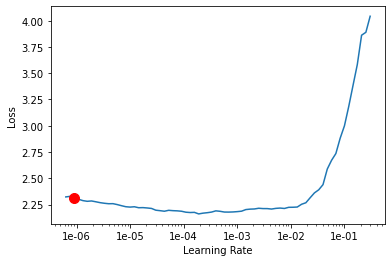

In [52]:
learner.recorder.plot(suggestion=True)

In [26]:
lr = 1e-5

In [27]:
learner.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.479432,2.407869,0.446458,0.446747,03:49
1,0.462595,2.498089,0.453438,0.456494,03:50


KeyboardInterrupt: 

In [20]:
learner.save('gpt2_clas-frag128')
#learner.load('gpt2_clas')

### Evaluate Classifier

Evaluate on the proxy task -- classifying fixed-length chunks of bootleg score features.

In [28]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_df, test_df, tokenizer=cust_tok, vocab=transformer_vocab,
                                  include_bos=False, include_eos=False, pad_first=False, pad_idx=pad_idx, 
                                  bs=bs, num_workers=1)

In [29]:
learner.validate(data_clas_test.valid_dl)

[2.9551425, tensor(0.3919), tensor(0.3957)]

Evaluate on the original task -- classifying pages of sheet music.  We can evaluate our models in two ways:
- applying the model to a variable length sequence
- applying the model to multiple fixed-length windows and averaging the predictions

First we evaluate the model on variable length inputs.  Report results with and without applying priors.

In [23]:
train_fullpage_df = pd.read_csv(bpe_path/'train_df.fullpage.char.csv')
valid_fullpage_df = pd.read_csv(bpe_path/'valid_df.fullpage.char.csv')
test_fullpage_df = pd.read_csv(bpe_path/'test_df.fullpage.char.csv')

In [24]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df,
                                       tokenizer=cust_tok, vocab=transformer_vocab, include_bos=False, 
                                       include_eos=False, pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [25]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_fullpage_df, databunch=data_clas_test)
(acc, acc_with_prior), (f1, f1_with_prior)

((0.3688156008720398, 0.40254873037338257),
 (0.3845426492825089, 0.39610937114910577))

Now we evaluate the model by considering multiple fixed-length windows and averaging the predictions.

In [26]:
test_ensemble_df = pd.read_csv(bpe_path/'test.ensemble64.char.csv')

FileNotFoundError: [Errno 2] File /home/dyang/InstrumentID/train_data/test.ensemble64.char.csv does not exist: '/home/dyang/InstrumentID/train_data/test.ensemble64.char.csv'

In [ ]:
data_clas_test = TextDataBunch.from_df(bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df,
                                       text_cols = 'text', label_cols = 'label', tokenizer=cust_tok, 
                                       vocab=transformer_vocab, include_bos=False, include_eos=False, 
                                       pad_first=False, pad_idx=pad_idx, bs=bs, num_workers=1)

In [ ]:
(acc, acc_with_prior), (f1, f1_with_prior) = eval_models.calcAccuracy_fullpage(learner, bpe_path, train_fullpage_df, valid_fullpage_df, test_ensemble_df, databunch=data_clas_test, ensembled=True)
(acc, acc_with_prior), (f1, f1_with_prior)

### Error Analysis

In [42]:
interp = ClassificationInterpretation.from_learner(learner)

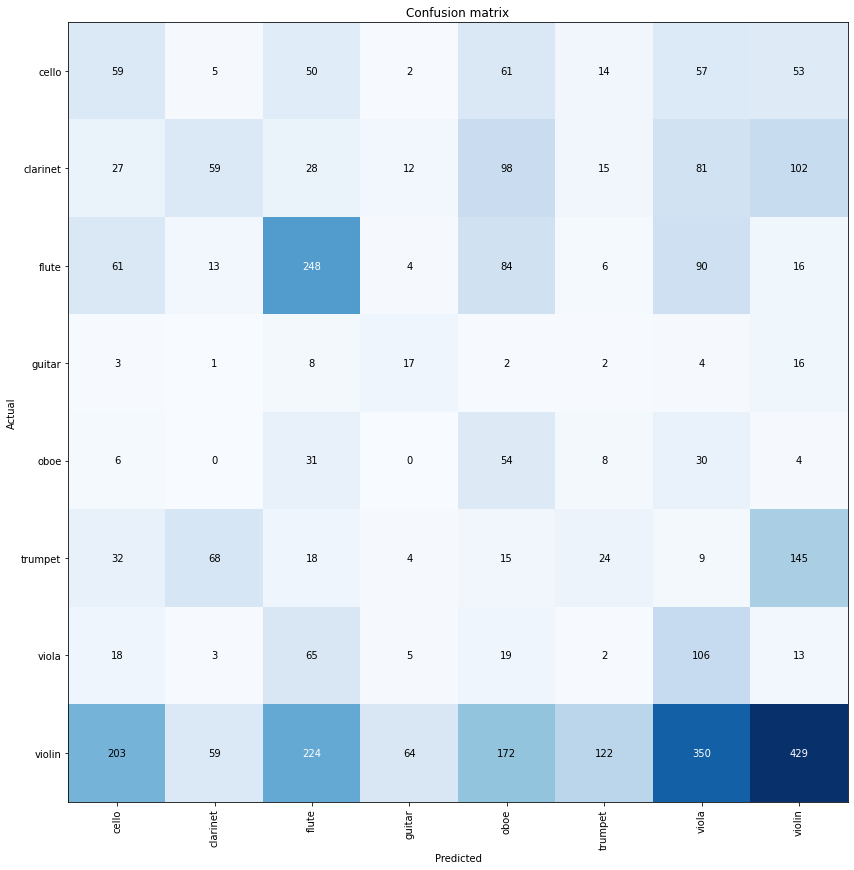

In [43]:
interp.plot_confusion_matrix(figsize=(12,12))

<BarContainer object of 3 artists>

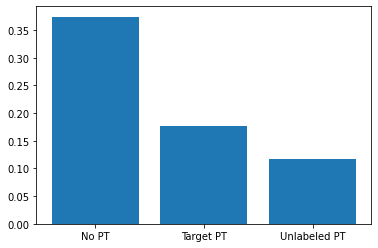

In [4]:
import matplotlib.pyplot as plt
plt.bar(['No PT','Target PT','Unlabeled PT'],[.374,.176, 0.117])

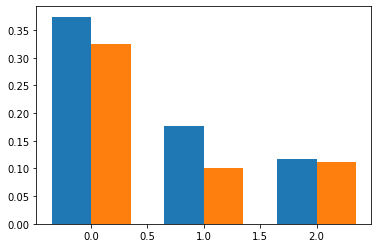

In [7]:
import numpy as np
labels = ['No PT','Target PT','Unlabeled PT']
men_means = [.374,.176, 0.117]
women_means = [.324,.101, 0.1119]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Proxy')
rects2 = ax.bar(x + width/2, women_means, width, label='Fullpage')
